In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from lib import jsoncorpus, datastuff, analysis
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.svm
import sklearn.decomposition
import sklearn.cluster
from lib.scikitComponents import *
import itertools
import collections
import sklearn.metrics

# LDA

## Data preprocessing

In [6]:
# Load in the previously created corpus and dictionary of scraped sites
#dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')
dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_")

Done.


In [7]:
# Link topics to URLs
meta = list(zip(dmoz_data['urls'], dmoz_data['dmoz_categories']))
# Build array of class labels
classes, top_categories, dmoz_encoder = datastuff.encode_dmoz_categories(dmoz_data['dmoz_categories'])
# Set up datasets
X = np.array(corpus)
y = classes

## Define a classification pipeline for the corpus data

The Pipeline() object chains together objects from the lib.scikitComponents file, so that they can be used as part of a scikit-learn classification pipeline

In [8]:
def lda_feature_pipeline(num_topics):
    return sklearn.pipeline.Pipeline([
            ('lda_model', LDAModel(dictionary, num_topics)),
            ('matrix_builder', TopicMatrixBuilder(num_topics))
            ])

Define a classifier (decision trees), and chain the preprocessing step to the classifier

In [9]:
classifier = sklearn.ensemble.ExtraTreesClassifier(random_state=0, n_estimators=100, oob_score=True, bootstrap=True, n_jobs=4)
#classifier = sklearn.tree.DecisionTreeClassifier()#(random_state=0, n_estimators=100, oob_score=True, bootstrap=True, n_jobs=4)

clf = sklearn.pipeline.Pipeline([
    ('preprocess_meta', lda_feature_pipeline(len(topcategories))),
    ('classification', classifier)])

### Build a training and test set

This may either be done from the full dataset, *or* from a dataset with **equal class proportions**.

In [10]:
PROPORTIONAL = False
if PROPORTIONAL:
    prop_X, prop_y = datastuff.make_proportional(X, y, min_size=200)
    
    ind_train, ind_test = next(iter(sklearn.cross_validation.StratifiedShuffleSplit(prop_y, test_size = 0.25)))
    X_train , X_test, y_train, y_test = (prop_X[ind_train], prop_X[ind_test], prop_y[ind_train], prop_y[ind_test])
else:
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y)
counts =collections.Counter(y_test)
"".join(["{}: {}     ".format(dmoz_encoder.inverse_transform(k), counts[k]) for k in counts.keys()])

'arts: 45     business: 60     computers: 55     games: 23     health: 29     home: 24     kids and teens: 10     news: 49     recreation: 38     reference: 43     regional: 3     science: 50     shopping: 29     society: 44     sports: 98     '

## Run the classifier

We can use the meta corpus or the full body corpus here, just by replacing a single argument

The data is split in to training and test sets, and then fit to the training set. The LDA model is generated ***only*** from the training set, not the testing set.

In [11]:
#sklearn.cross_validation.cross_val_score(clf, corpus, classes)
scores = sklearn.cross_validation.cross_val_score(clf, X, classes, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.35 (+/- 0.04)


### Find the score for each category. 

Note that if the classifier assigned *random* categories, the score would be $\frac{1}{\textrm{num categories}}$. Instead, it is actually quite high in some casses, indicating a moderate ammount of succcess (given how naive this is!)

In [17]:
model = clf.fit(X_train, y_train)
print model.score(X_test, y_test)
predicted = model.predict(X_test)

0.433333333333


In [22]:
print sklearn.metrics.classification_report(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)

             precision    recall  f1-score   support

       arts       0.36      0.20      0.26        45
   business       0.57      0.38      0.46        60
  computers       0.42      0.58      0.48        55
      games       0.73      0.35      0.47        23
     health       0.42      0.62      0.50        29
       home       0.22      0.29      0.25        24
kids and teens       0.50      0.30      0.37        10
       news       0.68      0.43      0.53        49
 recreation       0.24      0.11      0.15        38
  reference       0.21      0.35      0.26        43
   regional       0.00      0.00      0.00         3
    science       0.45      0.46      0.46        50
   shopping       0.48      0.41      0.44        29
    society       0.30      0.14      0.19        44
     sports       0.53      0.82      0.65        98

avg / total       0.44      0.43      0.42       600



/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


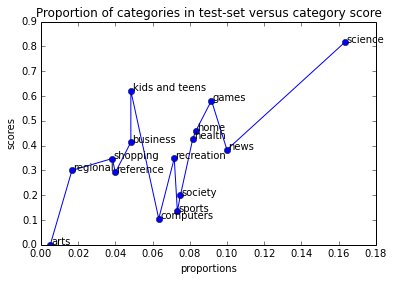

In [23]:
analysis.plot_proportion_investigation(predicted, dmoz_encoder, y_test)

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


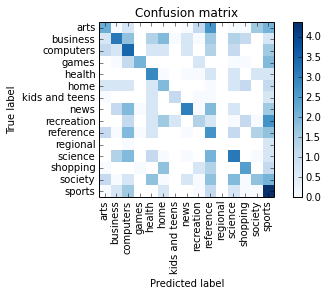

[[ 9  1  2  0  0  0  0  1  3 14  0  1  1  5  8]
 [ 2 23  6  0  4  7  1  2  1  5  0  4  3  0  2]
 [ 3  2 32  0  2  2  0  2  0  4  0  3  0  0  5]
 [ 0  1  3  8  0  0  0  0  2  0  0  1  1  0  7]
 [ 0  0  0  0 18  1  0  1  1  2  0  2  0  2  2]
 [ 2  2  2  0  2  7  0  0  0  1  0  2  3  0  3]
 [ 1  0  0  0  2  0  3  0  1  1  0  0  0  0  2]
 [ 0  3  7  1  2  0  0 21  1  7  0  2  0  0  5]
 [ 0  0  3  0  2  5  2  0  4  2  0  1  3  1 15]
 [ 3  1  7  1  2  0  0  1  0 15  0  3  0  4  6]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  4  7  0  3  1  0  1  0  8  0 23  0  1  2]
 [ 1  0  0  1  0  6  0  0  2  4  0  0 12  0  3]
 [ 3  1  2  0  6  1  0  2  1  6  0  7  1  6  8]
 [ 1  2  5  0  0  2  0  0  1  3  0  2  1  1 80]]


In [24]:
cm = sklearn.metrics.confusion_matrix(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)
analysis.plot_confusion_matrix(np.log(cm), labels= dmoz_encoder.classes_)
plt.show()
print cm